In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# funsgi 
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


def plot_rgb(image):
    plt.figure(figsize=(10,10))
    # plt.axis('off')
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



def plot_gray(image):
    plt.figure(figsize=(20,10))
    # plt.axis('off')
    return plt.imshow(image, cmap='Greys_r')
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)


def get_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        # and the size is not too big
        if len(approx) == 4 and cv2.contourArea(c) < 700000 and cv2.contourArea(c) > 10000:
            return approx

def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


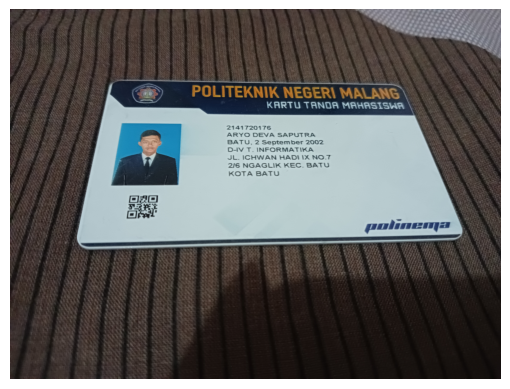

In [3]:
image = cv2.imread('dataset/85.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

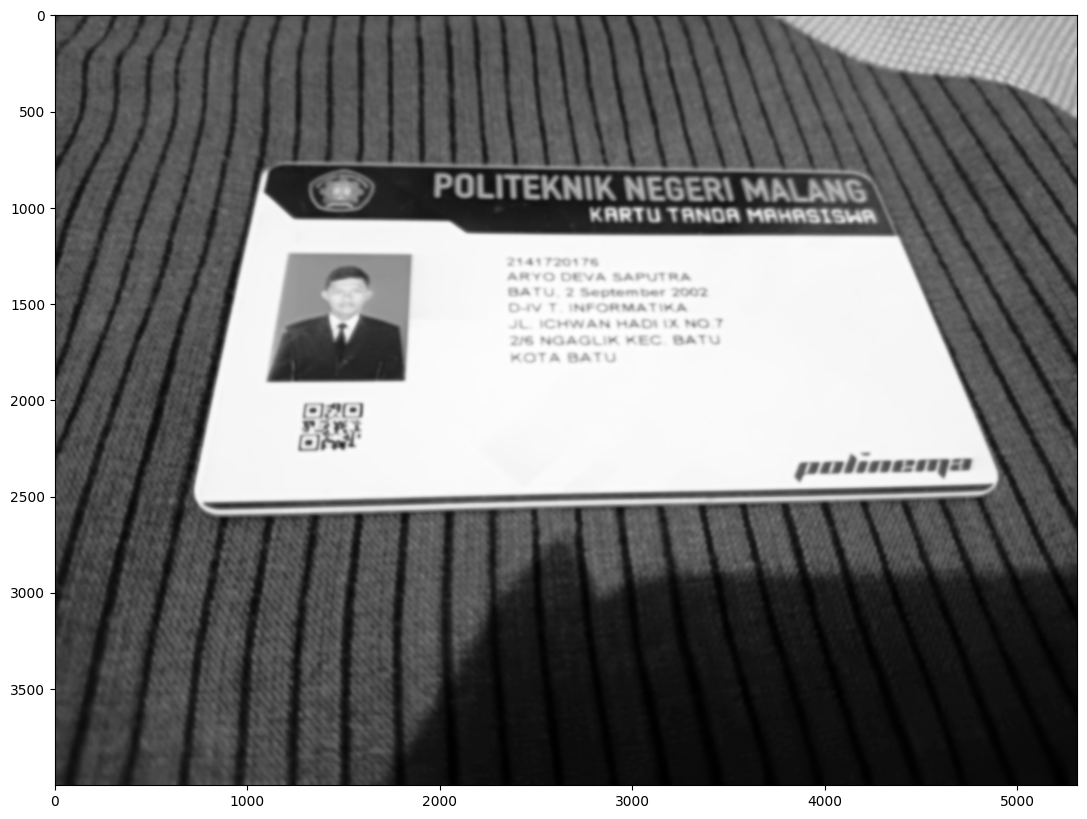

In [4]:
#downscale untuk mempercepat proses
resize_ratio = 4000 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# hilangkan noise
blurred = cv2.GaussianBlur(gray, (51, 51), 0)
plot_gray(blurred)

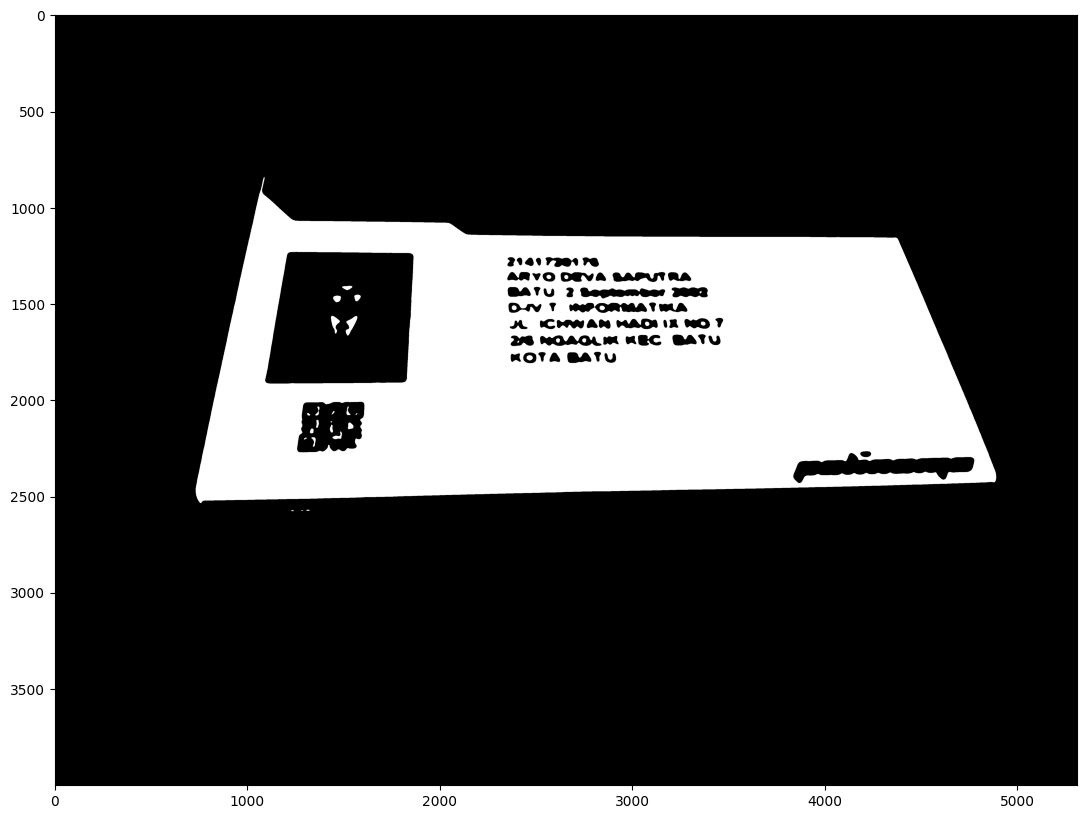

In [5]:
# thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(blurred, 170, 255, cv2.THRESH_BINARY)[1]
plot_gray(thresh)

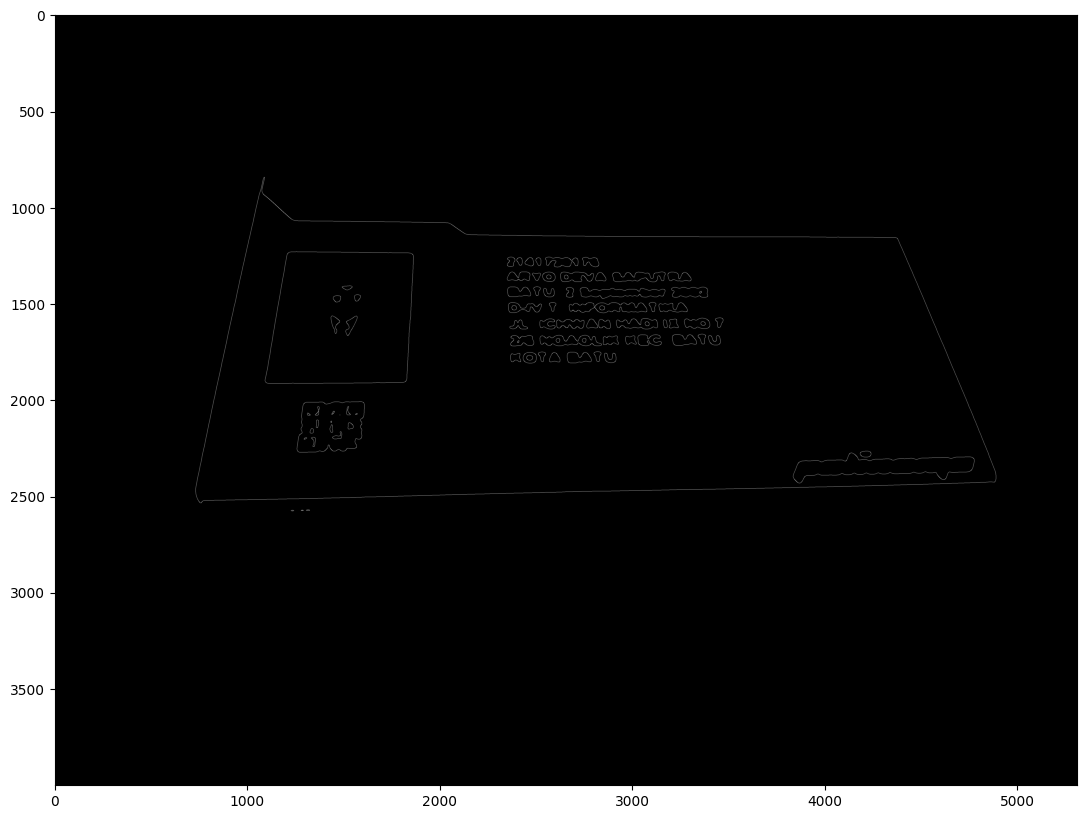

In [6]:
edged = cv2.Canny(thresh, 100, 200, apertureSize=3)
plot_gray(edged)

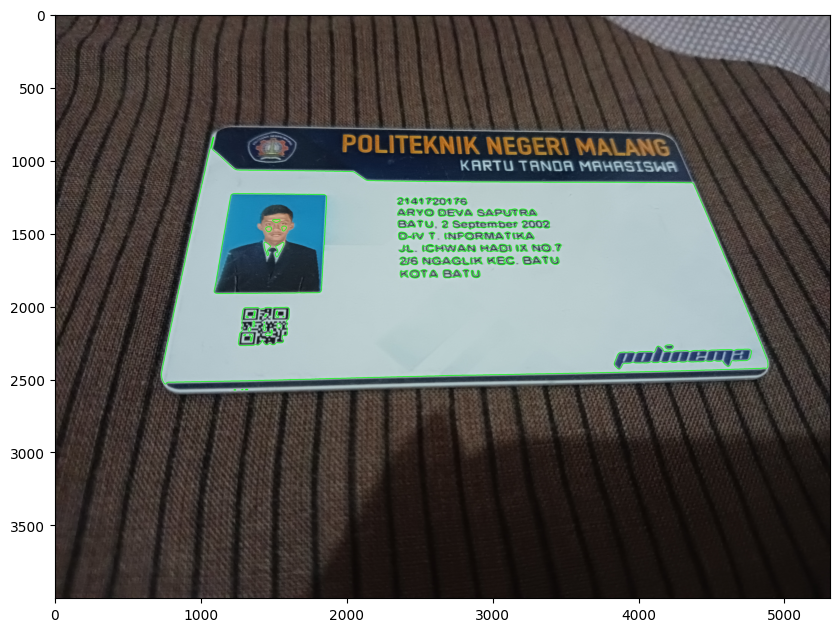

In [7]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

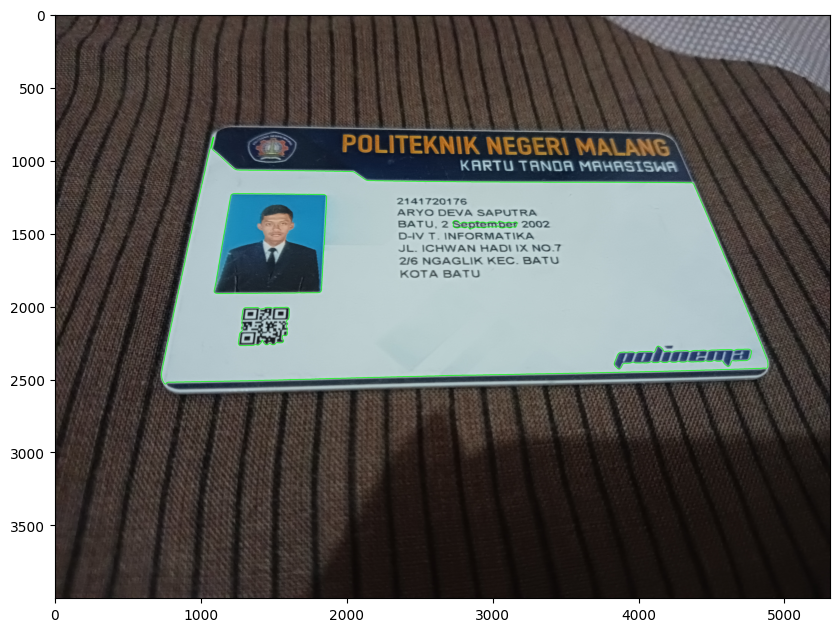

In [8]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [9]:
get_contour(largest_contours)

array([[[1211, 1235]],

       [[1094, 1908]],

       [[1819, 1904]],

       [[1858, 1244]]], dtype=int32)

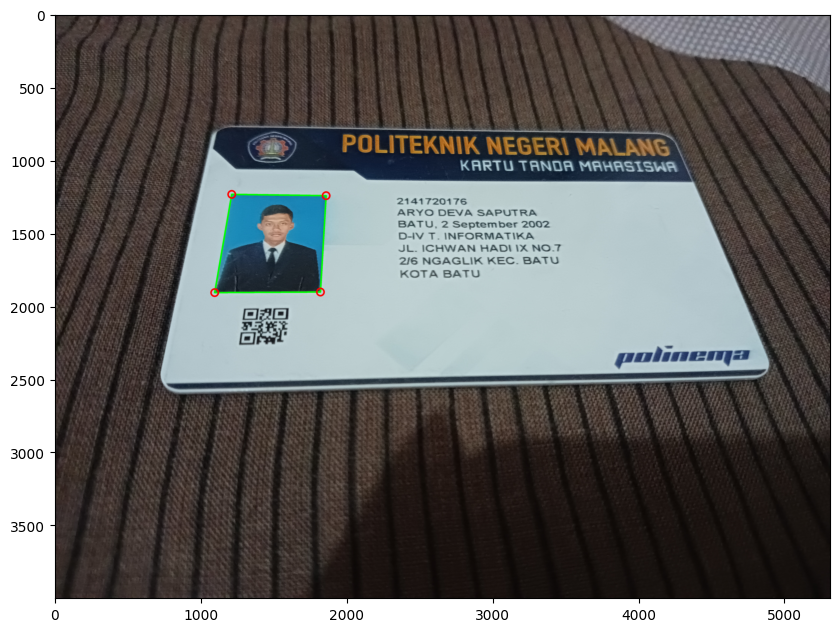

In [21]:
photo_contour = get_contour(largest_contours)
image_with_photo_contour = cv2.drawContours(image.copy(), [photo_contour], -1, (0, 255, 0), 10)
# draw circle at each corner
for corner in photo_contour:
    cv2.circle(image_with_photo_contour, tuple(corner[0]), 25, (0, 0, 255), 10)
plot_rgb(image_with_photo_contour)

In [11]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

(<Axes: title={'center': 'Output'}>,
 Text(0.5, 1.0, 'Output'))

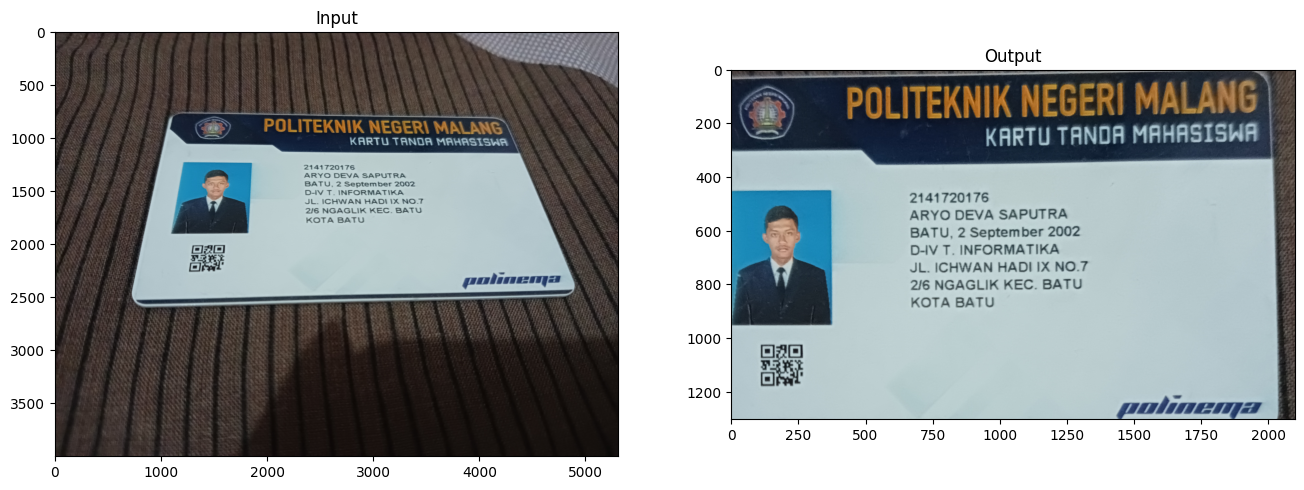

In [15]:
rect = contour_to_rect(photo_contour)
pts1 = np.float32(rect)
# pts2 = np.float32([[375,25],[375,525],[0,525],[0,25]])
# pts2 = np.float32([[0,525],[0,25],[375,25],[375,525]])
pts2 = np.float32([[0, 450], [375, 450], [375, 950], [0, 950]])
# pts2 = np.float32([[100, 400], [475, 400], [475, 900], [100, 900]])
# pts2 = np.float32([[375, 525], [0, 525], [0, 25], [375, 25]])
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(image,M,(2100,1300))

plt.figure(figsize=(16,10))
plt.subplot(121),plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),plt.title('Input')
plt.subplot(122),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('Output')

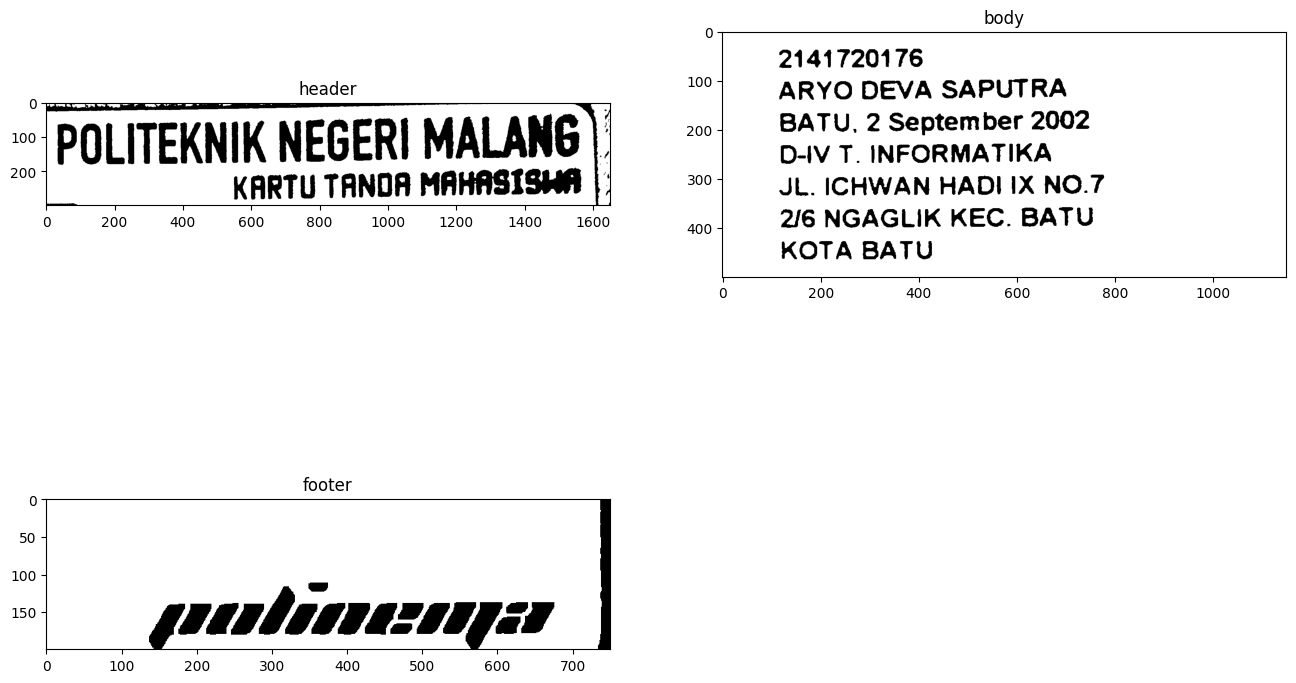

In [18]:
text_area = dst
gray_text = cv2.cvtColor(text_area, cv2.COLOR_BGR2GRAY)

header = gray_text[0:300, 400:2050]
header_thres = cv2.threshold(header, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
header_close = cv2.morphologyEx(header_thres, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

body = gray_text[420:920, 550:1700]
body_thres = cv2.threshold(body, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
body_close = cv2.morphologyEx(body_thres, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
body_close = 255 - body_close

footer = gray_text[1100:1350, 1300:2050]
footer_thres = cv2.threshold(footer, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
footer_close = cv2.morphologyEx(footer_thres, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=3)
footer_close = 255 - footer_close

plt.figure(figsize=(16,10))
plt.subplot(221),plt.imshow(header_close, cmap='gray'),plt.title('header')
plt.subplot(222),plt.imshow(body_close, cmap='gray'),plt.title('body')
plt.subplot(223),plt.imshow(footer_close, cmap='gray'),plt.title('footer')
plt.show()

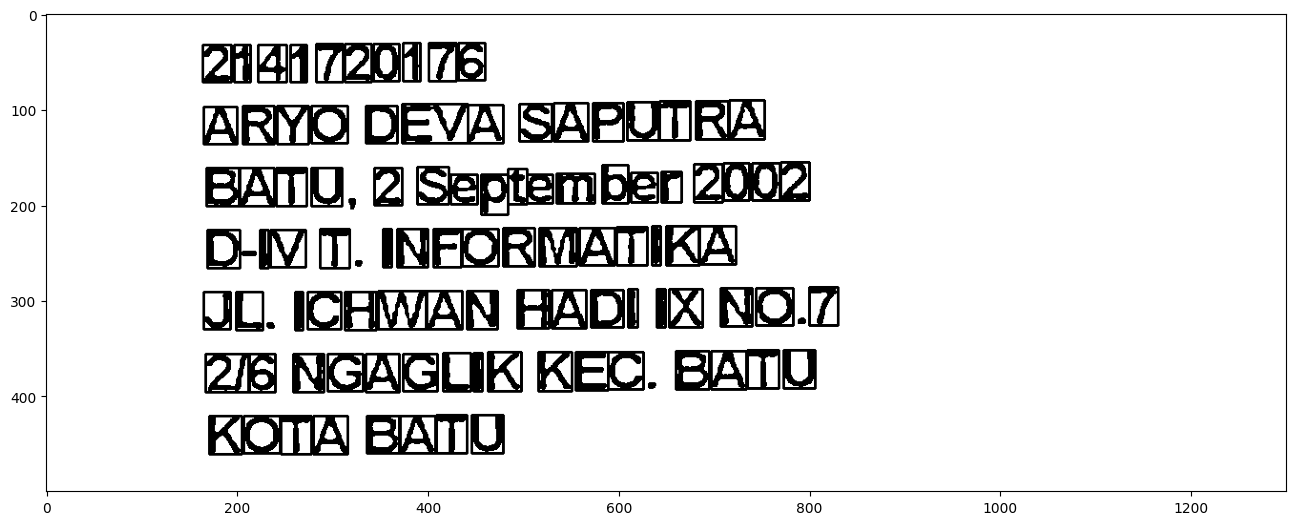